### Deep Learning Supervised Text Classification
- BiLSTM

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 5.2 MB/s 
     |████████████████████████████████| 106 kB 55.1 MB/s 


In [4]:
# Importing required libraries
import pandas as pd
import re
import requests
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import requests
import json

In [5]:
# Install required nltk resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Load Data

In [6]:
# Pick a minority category of interest
focus_cat = 'hydraulic fluid or oil leak'
fn = '/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/hydraulic fluid or oil leak_577_out_df_temp.csv'
df = pd.read_csv(fn)
df = df[['text', 'category']]

# Convert category to binary 1/0
# Remeber that 1 is a rule-book hit & not necessarily the 'truth'
df['category'] = df['category'].apply(lambda x : x.replace("*** Not Classified", "0"))
df['category'] = df['category'].apply(lambda x : x.replace(focus_cat, "1"))
df['category'] = df['category'].astype(int)
df

,text,category
0,foreign body entered employee's (l) eye while ...,0
1,drainage pipe damaged at ~2.2 m depth. see sup...,0
2,robodrill spider excavator being operated when...,1
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,"other fall to lower level, unspecified an empl...",0
93854,injured by slipping or swinging object held by...,0
93855,"direct exposure to electricity, greater than 2...",0


### Data Prepatation

In [7]:
STOP_SENTS = ['migrated from legacy cairs', 'migrated from cairs']

f = open('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/data/us2gb.json')
US2GB = json.load(f)
f.close()

def remove_stop_sentences(in_doc):
    for i, sen in enumerate(STOP_SENTS):
        if i==0:
            rep_doc = in_doc
        else:
            rep_doc = out_doc
        out_doc = rep_doc.replace(f'{sen}', '') 
    out_doc = re.sub(' +', ' ', out_doc)    
    return(out_doc)

def americanize(in_doc):
    for american_spelling, british_spelling in US2GB.items(): 
        in_doc = re.sub(f'(?<![a-zA-Z]){british_spelling}(?![a-z-Z])', american_spelling, in_doc)
    return(in_doc)

# Main denoising function
def denoise_text(txt):
    # Strip html if any.
    soup = BeautifulSoup(txt, "html.parser")
    txt = soup.get_text()

    # Replace contractions in string of text. For ex. didn't -> did not
    txt = contractions.fix(txt)

    # Change to lower case
    txt = txt.lower()

    # Remove any defined stop sentences
    txt = remove_stop_sentences(txt)

    # Convert British to American spelling
    #txt = americanize(txt)
    return txt

In [8]:
# Test the denoising function
chk_text = "<p>she didn't TELL me anything </br> about what's gonna <html> happen in the end but did want to optimise the colours migrated from cairs"
denoise_text(chk_text)

'she did not tell me anything about what is going to happen in the end but did want to optimise the colours '

In [35]:
# Normalization may include everal step
# Each function below fulfills a (potential) step in normalization

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

# Define the normalization pipeline
# Comment out steps not used
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    # TODO - Experiment with the below options
    # Inuitively, stopwords should not be removed as they may impact
    # semantic meaning.
    #words = remove_stopwords(words) 
    #words = stem_words(words)
    #words = lemmatize_verbs(words)
    return words


In [10]:
# Let's test the individual normalization functions
print("Remove non_ascii: ", remove_non_ascii(['h', 'ॐ', '©', '1']))
print("To lowercase: ", to_lowercase(['HELLO', 'hiDDen', 'wanT', 'GOING']))
print("Remove punctuation: ", remove_punctuation(['hello!!', 'how?', 'done,']))
print("Replace numbers: ", replace_numbers(['1', '2', '3']))
print("Remove stopwords: ", remove_stopwords(['this', 'and', 'amazing', 'not', 'no', 'yes']))
print("Stem words: ", stem_words(['beautiful', 'flying', 'waited']))
print("Lemmatize verbs: ", lemmatize_verbs(['hidden', 'walking', 'ran']))

# Now apply the pipeline (on a test)
print("Normalize text: ", normalize_text(['hidden', 'in', 'the', 'ALMIRAH', 'he', 'WAited', '2', 'ॐ', 'hours!!']))

Remove non_ascii:  ['h', '', '', '1']
To lowercase:  ['hello', 'hidden', 'want', 'going']
Remove punctuation:  ['hello', 'how', 'done']
Replace numbers:  ['one', 'two', 'three']
Remove stopwords:  ['amazing', 'yes']
Stem words:  ['beauty', 'fly', 'wait']
Lemmatize verbs:  ['hide', 'walk', 'run']
Normalize text:  ['hide', 'in', 'the', 'almirah', 'he', 'wait', 'two', 'hours']


In [11]:
# Tokenize text into words
def simple_tokenize(text):
    return nltk.word_tokenize(text)

# Check the function
sample_text = 'he did not say anything  about what is going to  happen'
print("tokenize results :", simple_tokenize(sample_text))

tokenize results : ['he', 'did', 'not', 'say', 'anything', 'about', 'what', 'is', 'going', 'to', 'happen']


In [36]:
# Now create a simple function to denoise, normalize and apply simple tokeniser to text
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(simple_tokenize(text))])
    return text

In [37]:
re.sub(" s ", " ", text_prepare("I am not gonna go to the shop's to visualise"))

'i am not going to go to the shop to visualise'

In [14]:
#tqdm.pandas()
# Remove stop sentences & more than single spaces
#print('Removing stop sentences...')
#df['text'] = df['text'].progress_apply(lambda x: remove_stop_sentences(x))

# Convert all text to one dictionary (let's choose american english)
#print('\nAmericanizing...')
#df['text'] = df['text'].progress_apply(lambda x: americanize(x))

In [38]:
# Now apply the main text prep pipeline to all text:
# Takes about 7 hrs to run on Google CoLab
df['text'] = [text_prepare(x) for x in tqdm(df['text'])]

# Clean up on category encoding
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
print('Done!')
df.head()

100%|██████████| 93857/93857 [01:10<00:00, 1334.24it/s]

Done!


,text,category
0,foreign body enter employee l eye while grind ...,0
1,drainage pipe damage at twentytwo m depth see ...,0
2,robodrill spider excavator be operate when hos...,1
3,pressure hose make contact with light fit whil...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0


In [39]:
df['text'] = df['text'].apply(lambda x: re.sub(' s ', ' ', x))
df.head()

,text,category
0,foreign body enter employee l eye while grind ...,0
1,drainage pipe damage at twentytwo m depth see ...,0
2,robodrill spider excavator be operate when hos...,1
3,pressure hose make contact with light fit whil...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0


In [17]:
# Save the prepared dataset
filename = f'/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/data/prepared/{time.strftime("%y%m%d%H%M")}_prepared_data.csv'
df.to_csv(filename, index=False)

## Build Model

In [40]:
# Load modelling building libraries
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [20]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("/content/drive/MyDrive/Colab_Notebooks/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [21]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [22]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [23]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3136450   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 500

In [24]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'a skid steer hydraulic hose break cause no more than five gallons of hydraulic fluid to leak onto the grind at approximately one thousand, six hundred and fifteen on two million, one hundred and fifty-two thousand and twenty-two a logistics operator be transport a skid steer to the entrance of block 3c for relocation a hydraulic hose on the boom of the skid steer break cause less than five gallons of hydraulic fluid to leak onto the grind the leak be immediately notice and the machine be stop environmental swppp be notify and clean up procedures begin the actual severity and potential rat be select as an a1 due to minimal reversible environmental impact the equipment be shut down environmental be notify clean up procedures immediately take place all contaminate soil and diapers be pick up and dispose of into proper containments'

### Model Training & Evaluatrion

In [25]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
# Train the model
history = model.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=5,
                              batch_size=128,
                              verbose=1)

Epoch 1/5
 29/587 [>.............................] - ETA: 59:05 - loss: 0.0108 - accuracy: 0.9973

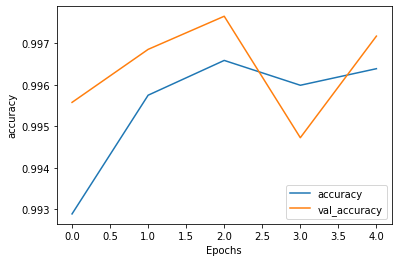

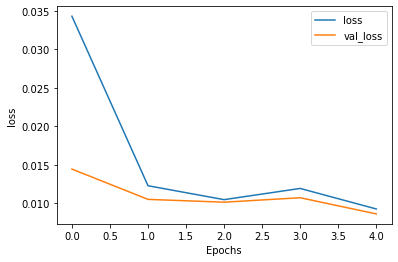

In [ ]:
# Plot training history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18665
           1       0.85      0.62      0.71       107

    accuracy                           1.00     18772
   macro avg       0.92      0.81      0.86     18772
weighted avg       1.00      1.00      1.00     18772





In [ ]:
# Deepdive into the results / take a closer look...
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test

# Dump results out for quick inspection in Excel (if required/desired)
tmp.to_csv('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/my_tmp_out.csv')

# Quick look at predicted positives
tmp[tmp['pred']==1]

,text,pred,rule_book
21679,cp20210044 env nanjv 80l hydraulic oil an exca...,1,0
26401,a skid steer hydraulic hose break because no m...,1,1
12669,hydraulic oil from a burst excavator hose have...,1,1
13652,hydraulic hose burst during quarry work a hydr...,1,1
514,faulty hydraulic hose hydraulic hose fail resu...,1,1
...,...,...,...
7054,hb082016 loss of containment from skyscape hyd...,1,0
1750,excavator encounter a hydraulic hose failure w...,1,1
51336,strike by discharge object or substance an emp...,1,1
4047,hb1117 hydraulic fit leak on starboard crane i...,1,1


In [ ]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
21679,cp20210044 env nanjv 80l hydraulic oil an excavator be grub off the midgrade ore pad when a rock become stick in the track as operator move forward the rock impact a cover plate buckle it which because the plate to damage the 4inch hydraulic suction line because 80l of hydraulic oil to be release to the grind work stop and scene freeze spill pad be immediately place on spill to contain area clean and dispose of contaminate soil,1,0
8937,hydraulic oil spill to grind approx two l due to hydraulic hose failure on scraper thirteen operator of scraper thirteen notice a spray mist of hydraulic oil come from articulation area of the scraper whilst operate in stage three lot seven scraper be shut downspill response initiate,1,0
14421,rear dump tractor trailer tip during offload while in the process of offload classfive aggregate to reinforce the crane stand a rear dump tractor trailer be approximately fifty elevate in preparation to dump his load when the driver claim that he felt the right rear of his trailer give way the driver attempt to dump his load but be tip on its side before he could finish the trailer break away from the truck as design and the truck remain in place the hydraulic cylinder do release approximately four gallons of hydraulic oil that be contain and remediate work stop and assess for any injuries spill contain and remediate use spill kit soil be overexcavated and place in an overpack drum,1,0
36,enm nacap 8t excavator experience hyd hose what happen 0930hrsenvironmental near miss enm when a hydraulic hose of an 8t cat excavator split during rehabilitation operations at kp 45the release of hydraulic oil be contain within and on the machine spill kit be locate on siteall contaminate materials absorbent pad be dispose of appropriately into the contaminate waste bag,1,0
16110,move diesel caddy and wheel come off the caddy damage containment and a minor spill occur a diesel caddy be be wheel to a laydown area by the storeman for off hire and one wheel come off the caddy allow the underside of the caddy to make contact with the grind the storeman notice the caddy leak diesel so a plant nappy be position under the caddy to contain the spill a spill kit be then deploy to further contain the spillclean up of the spill be conduct with the use spill kit items place into hazardous waste bag and then place into hazardous waste bin spill kit deploy to contain spill,1,0
5219,ro involve failure of clients equipmentduring commission of butane arm hose on propane arm rupture at height result in organic oil release workers receive minor splash to eye be take to paramedic for review workers return ok incident 31834ro involve failure of clients equipmentduring commission of butane arm hose on propane arm rupture at height result in organic oil release workers receive minor splash to eye be take to paramedic for review workers return oksummary during erc test on berth three butane arm z3502 a hydraulic control hose situate at height on the adjacent propane arm z3502 part result in approx 510l of hydraulic oil be release in the areafindings an exclusion zone have be erect around commission activities to prevent immediate access a test signal be send to initiate a qcdc release under normal operate condition while no work be be conduct on the old propane load arm logic link with the new butane arm result in hydraulic pressure activate in the old propane arm and subsequent failure of the control hose due to the hose failure occur approx 6m amove grade the area spray with a fine spray of oil be larger than if it be at grade immediately after the hydraulics be isolate commission team members engage the berth three spill kit to wipe up residue from the grind and equipment woodside operations report approx 510l of hydraulic oil be release due to the strong prevail wind move south east release oil be force back onto berth three no oil be report to have enter the ocean six scaffolders make their way up the stairway f


There are 12 entries (out of 107)...


In [ ]:
# Take a look at rule-book hits that did not have postive model hit...
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
table_count = len(table)
ruley_count = sum(y_test==1)
perc_calced = round(100*(table_count / ruley_count), 1)
print(f'\nThere are {table_count } entries (out of {ruley_count}, {perc_calced}%)...')

,text,pred,rule_book
30716,strike by discharge object or substance an employee be operate hydraulic equipment a directional bore machine when he think there be a leak he move the hose to check if there be a leak he place his hand on it and be inject by oil into his leave middle finger,0,1
2867,operator be perform excavations for new pump separator foundations in the process of perform such task operator strike a four fiberglass line with backhoe rear bucket because damage to line incident 36335morning meet take place bjsa be put in place crew break off and bjsa be further review individually and thoroughly by crew stop work authority be cover hazard be identify mitigations be review along with last minute risk assessments and assurance of one call be in place backhoe operator and spotter proceed to perform task previously review in meetingbjsa which be excavate foundations for a new production separator hydrovac have be perform on all line in immediate area all line be expose and all have a good view of all line excavations be nearly complete and operator be perform some slop as a final step on one of the excavations for easy accessegress this excavation be twentysix x26 x26 deep spotter and 2nd crew member alert operator to stop work as he be too close to the four fiberglass line line be on east side of excavation operator fail to stop excavation task spotter and 2nd crew member continue insist and use swa but again operator fail to stop excavation task second later operator strike the low pressure four fiberglass line with backhoe rear bucket because damage to line wateroil mixture be release from line low pressure line do not have constant fluids run through it this minimize the release oxy operations be notify they then shut the line in immediately line be repair and complete by end of shift see detail description,0,1
11403,whilst carry out pile activity a hydraulic hose connection fail because hyraulic oil to spray on to the adjacent build on the morning of monday 30th april at approx one thousand the hose fit on to the upper 22m in height gearbox of the pile rig fail this because a spray of fluid 3040ltrs to spray out to a distance of up to 60m and make contact with the neighbor build exterior steel claddingit be very windy with lot of raindue to the wet weather it be not notice until the follow day the extent of the spread of fluid unfortunately the subcontractor do not notify the site management team about the incident due to them not know about the oil release breakdown be report once inform the follow day the afw site team report it to the pc who airlined the incidentdawson wam stop work carry out the require repair and check the remain fittings for further sign of leak none be identifiedthe first stage of clean the neighbor build cladding within the construction area have already begin with an assessment take place for any other clean requirements outside of the construction area,0,1
534,damage plate compactor be discover on the north side of the hill divide construction and plant properties safety department be contact to investigate a damage plate compactor on the north side of the hill divide plant and construction properties the compactor be apparently damage by a metal track piece of mobile equipment judge by the damage and mark the damage because the compactor fuel and oil to spill onto the grind the total amount not exceed three gallons this incident appear to have ocurred within the previous two days judge by grind condition and track in the area but be not discover andor report until twelve million one hundred and eightytwo thousand and nineteen the damage equipment be remove from the area and place in a containment the contaminate soil be excavate and place in a fiftyfive gallon drum for proper disposal an investigation be launch and all civil operators and spotters be interview no employees be aware of the damage equipment and all report last see it in good condition the even of twelve million one hundred


There are 41 entries (out of 107, 38.3%)...


### Inference Checks

In [ ]:
#text = ['fall lower level less six feet employee miss step fell stationary semitruck injure back']
#text = ["mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs incident 34326on monday july thirty-one two thousand and seventeen celanese plant clear lake brazos e employee operate mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs see detail description"]
#text = ['contact hot object substances employee transport hot drip fluid use cook oil container fluid contact employee cause first second degree burn']
#text = ['strike discharge object substance lineman work aerial lift leak break hydraulic line inject fluid hand hospitalize']
text_raw = 'dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair'
text_raw = 'I was walking down the yard and I lost my footing and tripped and broke my leg'
text_raw = 'Employee noticed oil fluid leaking from hydraulic line'

In [ ]:
#with open('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/text_tokenizer.pkl', 'rb') as f:
#    tokenizer = pickle.load(f)

In [ ]:
# Create simple function for running inference on user input text
def inference_run():
    text_raw = input('Enter text:')
    # TODO - Apply text prep steps to user input steps
    text = [text_raw]
    text = np.array(text)
    text_all_tmp = np.concatenate((X_train, X_test), axis=0)
    text_tmp = np.array(X_train)
    tokenizer = Tokenizer(num_words=75000)
    tokenizer.fit_on_texts(text_tmp)

    sequences = tokenizer.texts_to_sequences(text)
    X_test_Glove_s = pad_sequences(sequences, maxlen=500)
    check_class = np.argmax(model.predict(X_test_Glove_s), axis=1)[0]
    if check_class == 1:
        # Use text wrap to avoid a paragraph of text printing as single line in output window
        lines = textwrap.wrap(text_raw, 80, break_long_words=False)
        for i, l in enumerate(lines):
            if i == 0:
                print(f'\n"{l}')
            elif i == len(lines)-1:
                print(f'{l}"')
            else:
                print(l)
        print('\nPredicted: ', focus_cat)
    else:
        print('\nNot classified...') 

In [ ]:
inference_run()

Enter text:dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair

"dozer along right way small leak hose observe dozer right way small leak
hydraulic hoseno contamination grind oil dozer notify operator damage hose
contact strathclyde send fitter site repair"

Predicted:  hydraulic fluid or oil leak


In [ ]:
# Save the model
filename = f'/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/models/{time.strftime("%y%m%d%H%M")}_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [26]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

In [27]:
imb_per = round(100*Counter(y_train)[1]/Counter(y_train)[0], 1)
print(f'{Counter(y_train)}, Percentage: {imb_per}%')

Counter({0: 74615, 1: 470}), Percentage: 0.6%


In [28]:
print('Train: ', Counter(y_train))
print('Test: ', Counter(y_test))

Train:  Counter({0: 74615, 1: 470})
Test:  Counter({0: 18665, 1: 107})


In [29]:
# Over and Under Sampling of Training Data
X = X_train_Glove
y = y_train

# Summarize again the class distribution
counter = Counter(y)
imb_per = round(100*Counter(y)[1]/Counter(y)[0], 1)
print(f'Base counts: {counter}, Percentage: {imb_per}%')

# Increase minority class to 10% of majority class (not undersampled)
over = SMOTE(sampling_strategy=0.1, random_state=193) #153

# Reduce majority class to 50% more than new minority class count
under = RandomUnderSampler(sampling_strategy=0.5, random_state=583) #183 

# Define pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset using the pipeline
X, y = pipeline.fit_resample(X, y)

# Summarize the new class distribution
counter = Counter(y)
imb_per = round(100*Counter(y)[1]/Counter(y)[0], 1)
print(f'Mods counts: {counter}, Percentage: {imb_per}%')

Base counts: Counter({0: 74615, 1: 470}), Percentage: 0.6%
SMOTE counts: Counter({0: 14922, 1: 7461}), Percentage: 50.0%


In [30]:
# Train the model
history = model.fit(X, y, validation_data=(X_test_Glove, y_test), epochs=5, batch_size=128, verbose=1)

Epoch 1/5
175/175 [==============================] - 1259s 7s/step - loss: 0.2570 - accuracy: 0.8937 - val_loss: 0.0631 - val_accuracy: 0.9816
Epoch 2/5
175/175 [==============================] - 1208s 7s/step - loss: 0.0915 - accuracy: 0.9702 - val_loss: 0.0473 - val_accuracy: 0.9849
Epoch 3/5
175/175 [==============================] - 1217s 7s/step - loss: 0.0551 - accuracy: 0.9825 - val_loss: 0.0472 - val_accuracy: 0.9872
Epoch 4/5
175/175 [==============================] - 1204s 7s/step - loss: 0.0400 - accuracy: 0.9883 - val_loss: 0.0189 - val_accuracy: 0.9949
Epoch 5/5
175/175 [==============================] - 1210s 7s/step - loss: 0.0375 - accuracy: 0.9893 - val_loss: 0.0314 - val_accuracy: 0.9922


In [31]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18665
           1       0.40      0.71      0.51       107

    accuracy                           0.99     18772
   macro avg       0.70      0.85      0.75     18772
weighted avg       0.99      0.99      0.99     18772



In [34]:
# Deepdive into the results / take a closer look...
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test

# Dump results out for quick inspection in Excel (if required/desired)
tmp.to_csv('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/my_tmp_out.csv')

# Quick look at predicted positives
tmp[tmp['pred']==1]

,text,pred,rule_book
46781,strike by swing or slip object other than hand...,1,0
19054,wood employee advise to self isolate by track ...,1,0
12085,a small amount of diesel be find to have leak ...,1,0
21679,cp20210044 env nanjv 80l hydraulic oil an exca...,1,0
26401,a skid steer hydraulic hose break cause no mor...,1,1
...,...,...,...
76577,contact with hot object or substances a linema...,1,1
8163,release of water from a hose no injuries repor...,1,0
13114,tool containers inappropriately pack with chem...,1,0
64493,catch in run equipment or machinery during reg...,1,0


In [33]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
46781,strike by swing or slip object other than handheld unspecified an employee be participate in concrete stress test operations a stress cable retention chuck slip cause the cable end to flip and puncture the employee right hand and abdomen,1,0
19054,"wood employee advise to self isolate by track trace wood employee advise to self isolate by track trace symptoms start over the weekend two hundred and twenty-one thousand, one hundred and twenty individual have be test and be await result report to site manager",1,0
12085,a small amount of diesel be find to have leak from a welfare unit which be position near c53 euchanhead a small amount of diesel be find to have leak from a welfare unit which be position near c53 euchanhead spill kit be immediately deploy and the spill be contain on the track near where the welfare unit be locate a large plant nappy be also position under the welfare units generator and fuel tank the contaminate material from the track be place on visqueen and will be up lift and dispose of in line with good environmental practiceno water course be affect by this incident,1,0
21679,cp20210044 env nanjv 80l hydraulic oil an excavator be grub off the midgrade ore pad when a rock become stick in the track as operator move forward the rock impact a cover plate buckle it which cause the plate to damage the 4inch hydraulic suction line cause 80l of hydraulic oil to be release to the grind work stop and scene freeze spill pad be immediately place on spill to contain area clean and dispose of contaminate soil,1,0
32898,catch in run equipment or machinery during regular operation employee catch his leave calf in a hydraulic spool machine during well drill,1,0
11923,finger become trap during torqueing activity ip be assist spool fix activity of exchanger 1e3201 ip be tighten fifty inch bolt by hand where rsl4 already fix for first sequence tighten torqueing pump operator operate pump without information and his finger become catch between the tail end of rsl four and nut work stop send to on site medical center for check up transfer to central hospital for further treatment,1,0
5572,the project secretary have minor cut to her finger while clean a scissor she be give a first aid treatment incident 31520the project secretary have minor cut to her finger while clean a scissor she be give a first aid treatment use a small plaster to cover the cut see detail description,1,0
11018,joint discover unrecorded joint on sh1 system break a task for reinstatement of mol pump one discharge control valve xzv241009 identify that a joint on drain valvehv241017 have be break without be record on the hydratight database report to the startup team apply ji1 and commence investigation,1,0
24885,first degree contact with a positive covid case first degree contact with a positive covid case quarantine for seven hundred and ten days,1,0
7329,swipe new replacement pass to access grind floor stairs lanyard extend approximately fifty cms 20ins then fly apart shower bits randomly several metres in all directions incident 28713old security pass spring return lanyard several years old in daily use fail cord break replacement obtain from receptionwhilst swipe new replacement pass to access grind floor stairs lanyard extend approximately fifty cms 20ins then fly apart shower bits randomly several metres in all directionsno one be injure see detail description,1,0



There are 115 entries (out of 107)...
